# First attempt at a data cube

This notebook is a first attempt at making a test image cube for validation. It uses `21cmFAST` to generate the cosmological signal and then the `pyobs21cm` package (subfolder) to apply SKA core's $(u,v)$ sampling pattern and noise for 1000hrs of observations to the coeval cube.

In [1]:
import numpy as np
import sys, glob, os, time
from multiprocessing import Pool, cpu_count
from pathlib import Path
import h5py

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc, colors, cm

In [54]:
rc("font", **{"family": "serif", "serif": ["times new roman"], "size": 15})
rc("text", usetex=True)
rc("axes", linewidth=1.5)

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import py21cmfast as p21c
print(f"Using 21cmFAST version {p21c.__version__}")

/home/agorce/envs/21cmfast/lib/python3.8/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/agorce/envs/21cmfast/lib/python3.8/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Using 21cmFAST version 3.2.1.dev76+gd6a6809


## Simulated cosmological signal

In [6]:
# user parameters
N = 100
L = 150. #Mpc
redshifts = np.array([8.0, 9.0])
nthreads = 5 #for parallelisation
# astro parameters
mturn = 9.0

In [7]:
# Set the various parameters
UParams = p21c.UserParams(HII_DIM=N,
                          BOX_LEN=L,
                          USE_INTERPOLATION_TABLES = True,
                          N_THREADS = nthreads,
                         )
CParams = p21c.CosmoParams() # Default
FOptions = p21c.FlagOptions(USE_MASS_DEPENDENT_ZETA=True,
                            USE_TS_FLUCT=False) 
AParams = p21c.AstroParams(M_TURN = mturn)

In [ ]:
coevals = p21c.run_coeval(
    redshift = list(redshifts),
    user_params = UParams,
    cosmo_params = CParams,
    astro_params = AParams,
    flag_options = FOptions,
    random_seed=12345
)
#coeval.save(fname='mycube.h5')

In [11]:
coeval = coevals[0]
xH = np.array(coeval.xH_box) #neutral 3D field
xion = np.array(1. - coeval.xH_box) #ionisation field
print('Mean ionisation fraction: %.3f' %(np.mean(xion)))

Mean ionisation fraction: 0.291


In [12]:
dTb = np.array(coeval.brightness_temp) #21cm brightness temperature field
print(np.mean(dTb))

15.605948


Text(0.5, 1.0, '$z=8.0$')

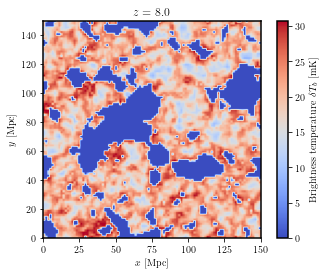

In [13]:
plt.imshow(dTb[:, :, N//2],
           origin='lower',
           cmap='coolwarm',
           extent=(0, L, 0, L))
plt.colorbar(label=r'Brightness temperature $\delta T_b$ [mK]')
plt.xlabel(r'$x$ [Mpc]')
plt.ylabel(r'$y$ [Mpc]')
plt.title(rf'$z={coeval.redshift:.1f}$')

In [14]:
fft_coeval = np.fft.fftshift(np.fft.fftn(dTb-dTb.mean(), axes=(0,1,2)))

In [15]:
kmin = 2.*np.pi/L
kmax = kmin*N/2

Text(0.5, 1.0, '$z=8.0$')

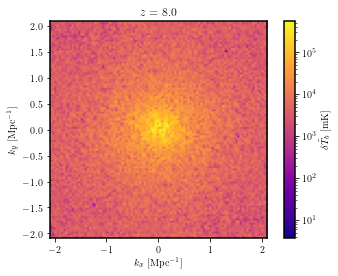

In [16]:
plt.imshow(np.abs(fft_coeval[:, :, N//2]),
           origin='lower',
           cmap='plasma',
           norm=colors.LogNorm(),
           extent=(-kmax, kmax, -kmax, kmax)
          )
plt.colorbar(label=r'$\delta \tilde{T}_b$ [mK]')
plt.xlabel(r'$k_x$ [Mpc$^{-1}$]')
plt.ylabel(r'$k_y$ [Mpc$^{-1}$]')
plt.title(rf'$z={coeval.redshift:.1f}$')

## Simulation instrumental effects

You need to first go into the `pyobs21cm/` folder and run `make`. Ensure to have `gsl`, `fftw` and `openmp` modules loaded if you are on an hpc. This should produce a `Compute_21cmPS.so` folder. For more information, go to https://bitbucket.org/caw11/pyobs21cm/src/Master/.

In [17]:
path2pyobs21 = "/home/agorce/pyobs21cm/"
sys.path.insert(1, path2pyobs21)

In [19]:
import simObs_21cmpy as p21obs

In [21]:
CMSENSE_FLAGS_ONLY = False #If you simply want to know settings to send to 21cmSENSE in order to generate the appropriate UV sampling for your cube
# The returned flags can then be used call uv_to_k_plus_calc_sense.

In [22]:
INST_BASE = path2pyobs21+'Uv_sampling_and_noise/'
FG = 'opt' # 'mod', 'opt' or None, latter processes clean simulation. See 21cmSENSE or 21cmMC papers for opt and mod. Roughly speaking: opt = foregrounds removed without residuals; mod = foreground limit assumes moderate spilling of foregrounds beyond theoretical wedge k-limit)
SIM_NOISE = True

## u-v sampling

Read the (u,v) sampling from file.

In [29]:
maskfile = Path('/home/agorce/pyobs21cm/Uv_sampling_and_noise/ska_central_2019.track_1.0hr_opt_z8.047_nu0.157_maskfile.h5')
with h5py.File(maskfile, "r") as hf:
    mask_for_ffted_coeval = hf["mask_sampling_box"][:]

Sampling pattern for a given frequency:

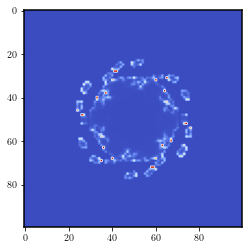

In [38]:
plt.imshow(np.fft.fftshift(np.abs(mask_for_ffted_coeval[:, :, 12])),
          cmap='coolwarm')

In [67]:
Filepath = Path('/home/agorce/pyobs21cm/Uv_sampling_and_noise/ska_central_2019.track_1.0hr_opt_z8.047_nu0.157.h5')
kx, ky, kz, Pnoise = p21obs.load_ks_Pnoise(Filepath=Filepath)
sim_fft_coeval = np.fft.fftn(coevals[0].brightness_temp, axes=(0, 1, 2))

Length of imported k and Pnoise arrays =  560960


/home/agorce/pyobs21cm/simObs_21cmpy.py:96: UserWarning: load_ks_Pnoise() -> loading data from h5 file
  warnings.warn("load_ks_Pnoise() -> loading data from h5 file")


## Apply noise and (u,v) sampling pattern

In [69]:
obs_coeval_fft = p21obs.get_obs_fft_coeval(
                    kx=kx,
                    ky=ky,
                    kz=kz,
                    Dim=N,
                    Len=L,
                    uv_mask=mask_for_ffted_coeval,
                    sim_noise=True,
                    sim_fft_data=sim_fft_coeval,
                    redshft=coevals[0].redshift,
                    omega_m=coeval.cosmo_params.OMb,
                    hlittle=coeval.cosmo_params.hlittle,
                )
obs_coeval = np.fft.irfftn(obs_coeval_fft, axes=(0, 1, 2), s=obs_coeval_fft.shape)

get_obs_fft_coeval() -> Applying UV sampling and adding random noise to the simulation passed
930561 1000000
random_sample_noise -> mean, variance =  (0.43199251912976194-4.9396930990042164e-17j) 92216.70729691992
(6.210899927697172-0.32609636758258814j)


In [73]:
print(obs_coeval.mean(), np.var(obs_coeval))

7.815970093361102e-20 52.568558300343774


-3.7608643e-06 88.12132


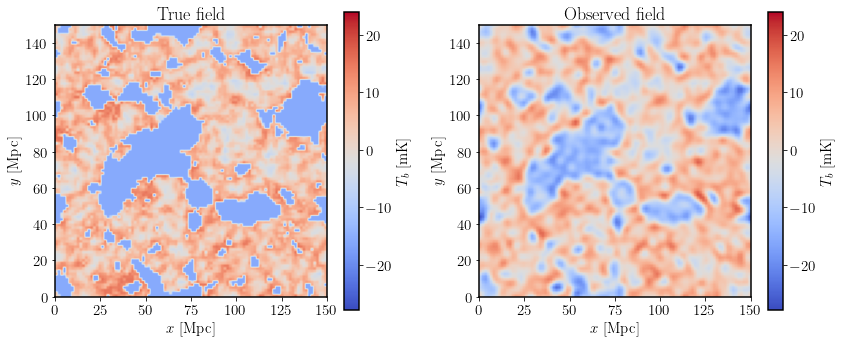

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
vmin = min(obs_coeval.min(), dTb_true.min())
vmax = max(obs_coeval.max(), dTb_true.max())

dTb_true = coevals[0].brightness_temp-coevals[0].brightness_temp.mean()
print(dTb_true.mean(), np.var(dTb_true))
im1 = axes[0].imshow(dTb_true[:, :, N//2],
                     cmap='coolwarm',
                     vmin=vmin, vmax=vmax,
                     origin='lower',
                    extent=(0, L, 0, L))
plt.colorbar(im1, label=r'$T_b$ [mK]', ax=axes[0])
axes[0].set_title('True field')

im2 = axes[1].imshow(obs_coeval[:, :, N//2],
                     cmap='coolwarm',
                     vmin=vmin, vmax=vmax,
                     origin='lower',
                    extent=(0, L, 0, L))
plt.colorbar(im2, label=r'$T_b$ [mK]', ax=axes[1])
axes[1].set_title('Observed field')

axes[0].set_xlabel(r'$x$ [Mpc]')
axes[1].set_xlabel(r'$x$ [Mpc]')
axes[0].set_ylabel(r'$y$ [Mpc]')
axes[1].set_ylabel(r'$y$ [Mpc]')
fig.tight_layout()

## Do everything in one

In [ ]:
print("Assuming foregrounds in wedge that extends moderately beyond the wedge's theoretical limit")
Inst_file=['ska512central.track_1.0hr_mod_z8.047_nu0.157.h5']#, 'ska512central.track_1.0hr_mod_z9.003_nu0.142.h5', 'ska512centraltrack_1.0hr_mod_z10.011_nu0.129.h5', 'ska_central_2019.track_1.0hr_mod_z13.204_nu0.100.h5']
for i in range(len(Inst_file)) :
    Inst_file[i] = INST_BASE + Inst_file[i]

In [91]:
# The following produces a single realisation of UV sampled noisy coeval cube and returns the power spectrum
print('\nObservations')
obs_spectra = p21obs.PS_from_obs_coeval(AParams=AParams, 
                                   FOptions=FOptions, 
                                   UParams=UParams, 
                                   CParams=CParams, 
                                   sim_noise=SIM_NOISE, 
                                   redshifts=list(redshifts),
                                   Inst=Inst_file )
# This computes the ps for the clean cube (Inst=[-1, -1])
print('\nTheory')
theory_spectra = p21obs.PS_from_obs_coeval(AParams=AParams, 
                                   FOptions=FOptions, 
                                   UParams=UParams, 
                                   CParams=CParams, 
                                   sim_noise=SIM_NOISE, 
                                   redshifts=list(redshifts),
                                   Inst=-np.ones(len(redshifts), dtype=int))

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']



Observations


/home/agorce/envs/21cmfast/lib/python3.8/site-packages/py21cmfast/_utils.py:821: UserWarning: Trying to remove array that isn't yet created: hires_vx
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/agorce/envs/21cmfast/lib/python3.8/site-packages/py21cmfast/_utils.py:821: UserWarning: Trying to remove array that isn't yet created: hires_vy
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/agorce/envs/21cmfast/lib/python3.8/site-packages/py21cmfast/_utils.py:821: UserWarning: Trying to remove array that isn't yet created: hires_vz
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/agorce/envs/21cmfast/lib/python3.8/site-packages/py21cmfast/_utils.py:821: UserWarning: Trying to remove array that isn't yet created: hires_vx_2LPT
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/agorce/envs/21cmfast/lib/python3.8/site-packages/py21cmfast/_utils.py:821: UserWarning: Trying to remove 

get_coeval_obs_PS() -> Instrumental info has been passed (/home/agorce/pyobs21cm/Uv_sampling_and_noise/ska_central_2019.track_1.0hr_opt_z8.047_nu0.157.h5) for z = 8.0, simulating a noisy observed box over simulation box with mean = 13.4 and var = 108.7
Length of imported k and Pnoise arrays =  560960
In get_obs_coeval() ->  /home/agorce/pyobs21cm/Uv_sampling_and_noise/ska_central_2019.track_1.0hr_opt_z8.047_nu0.157_maskfile.h5  mask_file exists, no need to call gen_mask via get_obs_fft_coeval
In get_obs_coeval() -> 21CMFAST simulation has been passed
In get_obs_coeval() -> Data shape after FFT =  (100, 100, 100)
In get_obs_coeval() -> Applying uv-sampling and adding noise
get_obs_fft_coeval() -> Applying UV sampling and adding random noise to the simulation passed
0.930561


/home/agorce/pyobs21cm/simObs_21cmpy.py:96: UserWarning: load_ks_Pnoise() -> loading data from h5 file
  warnings.warn("load_ks_Pnoise() -> loading data from h5 file")


random_sample_noise -> mean, variance =  (-0.11022810471949743+3.4106051316484806e-18j) 92650.4017700206
(9.067925418002668-0.06865961458193563j)
get_obs_coeval() -> FFTing simulation c2r
-2.9132252166164107e-18 67.37340489959783
get_coeval_obs_PS() -> sim size and type compared with noise (100, 100, 100) float32 (100, 100, 100) float32
8.392334e-11 67.37339
get_coeval_obs_PS() -> Instrumental info has been passed (/home/agorce/pyobs21cm/Uv_sampling_and_noise/ska_central_2019.track_1.0hr_opt_z9.003_nu0.142.h5) for z = 9.0, simulating a noisy observed box over simulation box with mean = 19.9 and var = 101.4
Length of imported k and Pnoise arrays =  557524
In get_obs_coeval() ->  /home/agorce/pyobs21cm/Uv_sampling_and_noise/ska_central_2019.track_1.0hr_opt_z9.003_nu0.142_maskfile.h5  mask_file exists, no need to call gen_mask via get_obs_fft_coeval
In get_obs_coeval() -> 21CMFAST simulation has been passed
In get_obs_coeval() -> Data shape after FFT =  (100, 100, 100)
In get_obs_coeval()

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


(3.310115437917819-0.1522946238565935j)
get_obs_coeval() -> FFTing simulation c2r
-1.524114168205415e-18 52.367974797226374
get_coeval_obs_PS() -> sim size and type compared with noise (100, 100, 100) float32 (100, 100, 100) float32
6.713867e-10 52.36799

Theory


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


get_coeval_obs_PS() -> Analysing clean simulation.
get_coeval_obs_PS() -> Analysing clean simulation.


In [ ]:
# read power spectra from weird outputs (everything runs in C)
kbins_obs, kbins_th = [], []
PS_obs_val, PS_th_val = [], []
PS_obs_error, PS_th_error = [], []
for i in range(len(theory_spectra)) :
    kbins_obs.append([obs_spectra[i].PS_k[j] for j in range(obs_spectra[i].PSbins)])
    PS_obs_val.append([obs_spectra[i].PS[j] for j in range(obs_spectra[i].PSbins)])
    PS_obs_error.append([obs_spectra[i].PS_error[j] for j in range(obs_spectra[i].PSbins)])
    
    kbins_th.append([theory_spectra[i].PS_k[j] for j in range(theory_spectra[i].PSbins)])
    PS_th_val.append([theory_spectra[i].PS[j] for j in range(theory_spectra[i].PSbins)])
    PS_th_error.append([theory_spectra[i].PS_error[j] for j in range(theory_spectra[i].PSbins)])

In [93]:
PS_th_val[0][:5], PS_obs_val[0][:4]

([1.413318157196045,
  5.937939643859863,
  26.148059844970703,
  37.759578704833984,
  38.324058532714844],
 [0.057593461126089096,
  4.649308204650879,
  16.923288345336914,
  21.13044548034668])

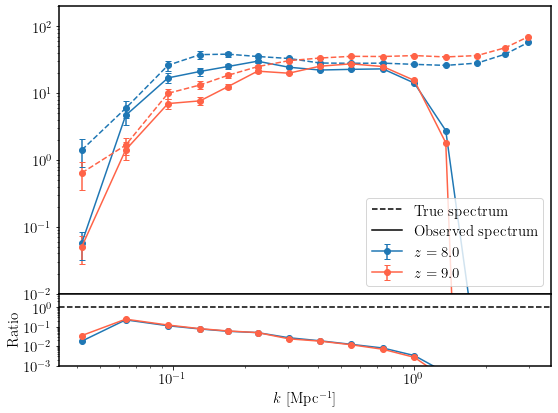

In [108]:
colorlist = ['C0', 'tomato']

fig, axes = plt.subplots(2, 1, figsize=(8, 6),
                         sharex=True,
                         gridspec_kw={'height_ratios':(4,1),
                                      'hspace':0})
for i, z in enumerate(redshifts):
    axes[0].errorbar(kbins_obs[i], PS_obs_val[i],
                 yerr=PS_obs_error[i],
                 color=colorlist[i],
                 label=rf'$z={z:.1f}$',
                 marker='o', capsize=3)
    axes[0].errorbar(kbins_th[i], PS_th_val[i],
                 yerr=PS_th_error[i],
                 color=colorlist[i],
                 marker='o', ls='--', capsize=3)
    axes[1].plot(kbins_th[i], np.array(PS_obs_error[i])/np.array(PS_th_val[i]),
                 color=colorlist[i], marker='o')
axes[0].plot([], [], color='k', ls='--', label='True spectrum')    
axes[0].plot([], [], color='k', ls='-', label='Observed spectrum')    
# plt.plot(k2, P2, color='k')
axes[0].legend(loc='lower right')
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_ylim(1e-2, 2e2)
axes[1].set_xlabel(r'$k$ [Mpc$^{-1}$]')
axes[1].set_ylabel('Ratio')
axes[1].axhline(1, ls='--', color='k')
axes[1].set_ylim(1e-3, 5)
fig.tight_layout()

## Foregrounds?

There are options to include foregrounds in the code. I haven't looked at them yet.

In [90]:
# Define the uv-noise files to be passed (these have been generated using Uv_sampling_and_noise/uv_to_k_plus_calc_sense.py)
if (FG == 'mod'):
    print("Assuming foregrounds in wedge that extends moderately beyond the wedge's theoretical limit")
    Inst_file=['ska512central.track_1.0hr_mod_z8.047_nu0.157.h5']#, 'ska512central.track_1.0hr_mod_z9.003_nu0.142.h5', 'ska512centraltrack_1.0hr_mod_z10.011_nu0.129.h5', 'ska_central_2019.track_1.0hr_mod_z13.204_nu0.100.h5']
elif (FG == 'opt'):
    print("Assuming foregrounds perfectly removed... Ha ha.... Good one!")
    Inst_file=['ska_central_2019.track_1.0hr_opt_z8.047_nu0.157.h5', 'ska_central_2019.track_1.0hr_opt_z9.003_nu0.142.h5', 'ska_central_2019.track_1.0hr_opt_z10.011_nu0.129.h5', 'ska_central_2019.track_1.0hr_opt_z13.204_nu0.100.h5']
else:
    Inst_file=[-1, -1, -1, -1]

Assuming foregrounds perfectly removed... Ha ha.... Good one!
